Computed Ignition Delay: 2.298e-01 seconds. Took 0.95s to compute


<IPython.core.display.Javascript object>


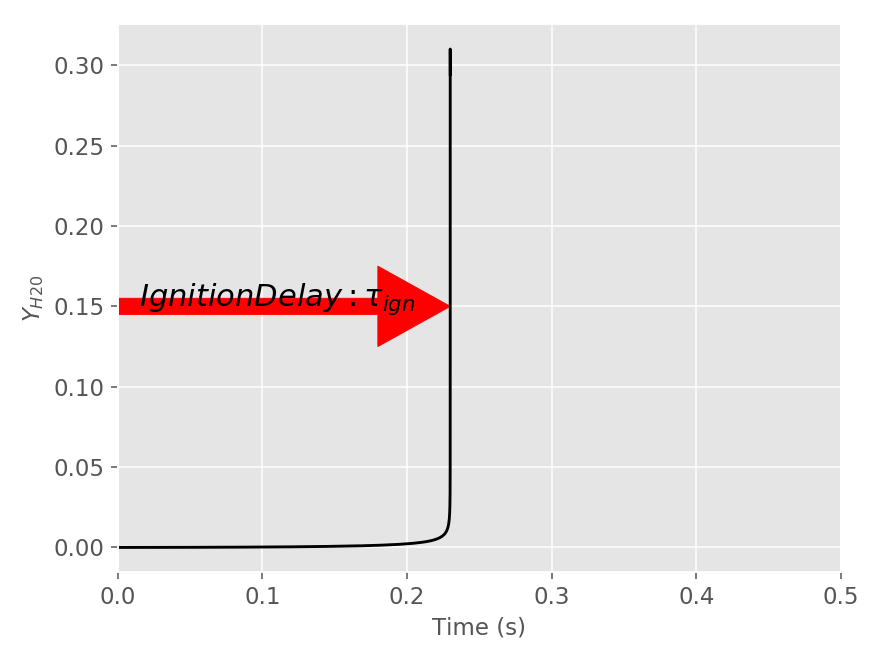

Computed Ignition Delay: 1.233e-05 seconds for T=2000K. Took 0.35s to compute


D:\MKWS\Anaconda2\lib\site-packages\ipykernel_launcher.py:133: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Computed Ignition Delay: 3.312e-05 seconds for T=1800K. Took 0.34s to compute
Computed Ignition Delay: 1.191e-04 seconds for T=1600K. Took 0.30s to compute
Computed Ignition Delay: 7.212e-04 seconds for T=1400K. Took 0.42s to compute
Computed Ignition Delay: 8.882e-03 seconds for T=1200K. Took 0.32s to compute
Computed Ignition Delay: 7.572e-02 seconds for T=1000K. Took 0.05s to compute
Computed Ignition Delay: 5.982e-01 seconds for T=950K. Took 0.65s to compute
Computed Ignition Delay: 9.828e-01 seconds for T=900K. Took 0.07s to compute
Computed Ignition Delay: 9.439e-01 seconds for T=850K. Took 0.03s to compute
Computed Ignition Delay: 6.700e-01 seconds for T=800K. Took 0.02s to compute
Computed Ignition Delay: 7.073e-01 seconds for T=750K. Took 0.01s to compute
Computed Ignition Delay: 2.623e-01 seconds for T=700K. Took 0.00s to compute
Computed Ignition Delay: 6.252e-08 seconds for T=650K. Took 0.00s to compute
Computed Ignition Delay: 9.063e-07 seconds for T=600K. Took 0.00s to co

<IPython.core.display.Javascript object>


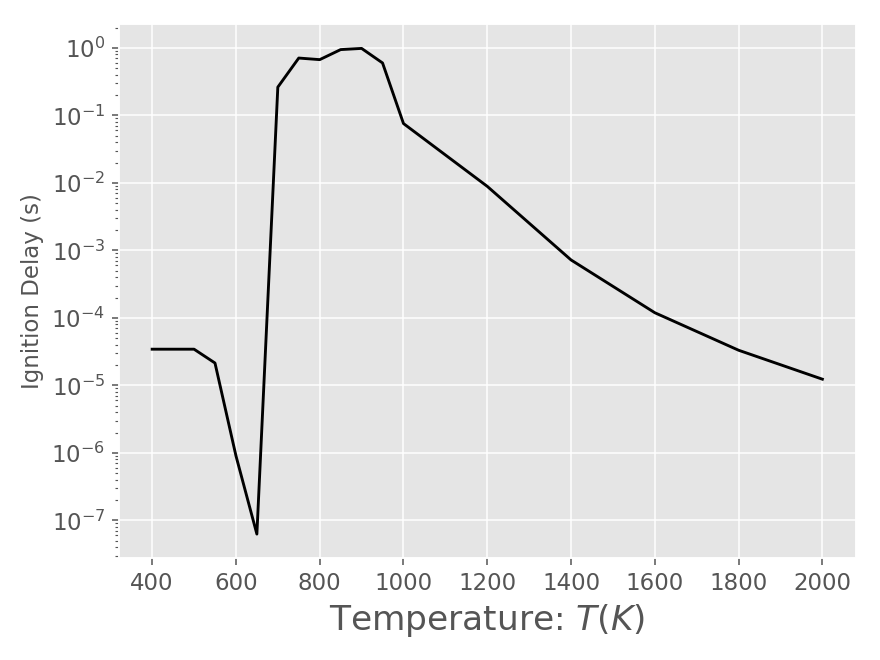

Text(0.5,0,u'Temperature: $T(K)$')

In [15]:
from __future__ import division
from __future__ import print_function

import pandas as pd
import numpy as np

import time

import cantera as ct


gas = ct.Solution('gri30.xml')


# Define the reactor temperature and pressure
reactorTemperature = 1000 #Kelvin
reactorPressure = 101325.0 #Pascals

gas.TP = reactorTemperature, reactorPressure

# Define the fuel, oxidizer and set the stechiometry
gas.set_equivalence_ratio(phi=1.0, fuel='CH4', oxidizer={'O2':1.0, 'N2':0.0})

# Create a batch reactor
r = ct.IdealGasReactor(contents=gas, name='Batch Reactor')
reactorNetwork = ct.ReactorNet([r])

# now compile a list of all variables for which we will store data
stateVariableNames = [r.component_name(item) for item in range(r.n_vars)]

# create a DataFrame
timeHistory = pd.DataFrame(columns=stateVariableNames)

def ignitionDelay(df, species):
    """
    This function computes the ignition delay from the occurence of the peak in species' concentration.
    """
    return df[species].idxmax()

t0 = time.time()

# This is a starting estimate. 
estimatedIgnitionDelayTime = 0.5

t = 0

counter = 1;
while(t < estimatedIgnitionDelayTime):
    t = reactorNetwork.step()
    if (counter%10 == 0):
        # We will save only every 10th value. Otherwise, this takes too long
        
        timeHistory.loc[t] = reactorNetwork.get_state()
    counter+=1

# We will use the 'H20' species to compute the ignition delay
tau = ignitionDelay(timeHistory, 'H2O')

#Toc
t1 = time.time()

print('Computed Ignition Delay: {:.3e} seconds. Took {:3.2f}s to compute'.format(tau, t1-t0))


 
#print plots
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib notebook

plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.autolayout'] = True

plt.style.use('ggplot')
plt.style.use('seaborn-pastel')

plt.figure()
plt.plot(timeHistory.index, timeHistory['H2O'],'-0')
plt.xlabel('Time (s)')
plt.ylabel('$Y_{H20}$')

plt.xlim([0,0.5])
plt.arrow(0, 0.15, tau, 0, width=0.01, head_width=0.05,
          head_length=0.05, length_includes_head=True, color='r', shape='full')
plt.annotate(r'$Ignition Delay: \tau_{ign}$', xy=(0,0), xytext=(0.015, 0.15), fontsize=16);


# List of all the temperatures we would like to run simulations at
T = [2000, 1800, 1600, 1400, 1200, 1000, 950, 900, 850, 800,
     750, 700, 650, 600, 550, 500, 450, 400]

estimatedIgnitionDelayTimes = np.ones(len(T))

# Make time adjustments for the highest and lowest temperatures. This we do empirically
estimatedIgnitionDelayTimes[:6] = 6*[0.1]
estimatedIgnitionDelayTimes[-2:] = 10
estimatedIgnitionDelayTimes[-1] = 100

# Now create a data Frame out of these
ignitionDelays = pd.DataFrame(data={'T':T})
ignitionDelays['ignDelay'] = np.nan


for i, temperature in enumerate(T):
    # Setup the gas and reactor
    reactorTemperature = temperature
    reactorPressure = 101325.0
    gas.TP = reactorTemperature, reactorPressure
    gas.set_equivalence_ratio(phi=1.0, fuel='CH4', oxidizer={'O2':1.0, 'N2':0.0})
    r = ct.IdealGasReactor(contents=gas, name='Batch Reactor')
    reactorNetwork = ct.ReactorNet([r])

    # Create and empty data frame
    timeHistory = pd.DataFrame(columns=timeHistory.columns)

    t0 = time.time()

    t = 0
    counter = 0
    while t < estimatedIgnitionDelayTimes[i]:
        t = reactorNetwork.step()
        if not counter % 20:
            timeHistory.loc[t] = r.get_state()
        counter += 1

    tau = ignitionDelay(timeHistory, 'H2O')
    t1 = time.time()

    print('Computed Ignition Delay: {:.3e} seconds for T={}K. Took {:3.2f}s to compute'.format(tau, temperature, t1-t0))

    ignitionDelays.set_value(index=i, col='ignDelay', value=tau)



fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(ignitionDelays['T'], ignitionDelays['ignDelay'],'-0')
ax.set_ylabel('Ignition Delay (s)')
ax.set_xlabel(r'Temperature: $T(K)$', fontsize=18)

